## Проект
<a id='intro'></a>

### Описание проекта <a id='begin'></a>
Для корректировки рекламного бюджета двух тарифов оператора сотовой связи необходимо оценить, какой тариф приносит больше денег.
Анализируемые дынные по тарифам представлены сведениями по потребляемым ресурсам (время разговора, SMS, Интернет-трафик) пользователей различных регионов РФ за 2018 год (500 клиентов выбраны случайно).

**Описание тарифов**

Тариф «Смарт»
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

Тариф «Ультра»
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

**Примечание:**
* «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
* Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.
* В данных вы найдёте звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.

### Импортируемые библиотеки

In [1]:
# блок импорта библиотек
import pandas as pd # для работы с данными
import seaborn as sb # библиотека доп графики
import matplotlib.pyplot as plt # для доп операций по графике
from scipy import stats as st # блок статистики для проверки статгипотез

### Константы

In [2]:
# параметр (константа), задающий формат даты
DATE_FORMAT = "%Y-%m-%d"

### Пользовательские функции

In [3]:
# блок пользовательских функций

def mf_df_info(m_df):
    """ Получение детальных сведений о полях DataFrame 
        =======================================================
        m_df: передается анализируемый DataFrame
        возвращаемое значение: DataFrame с описанием всех полей
    """
    field_names = ['Наименование поля', 'Тип данных', 'Первое непустое значение','Кол-во пустых значений'\
                   , '% пустых значений', 'Кол-во уникальных значений' ]
    row=[]
    table = []
    print('Размерность источника данных: ', m_df.shape)
    print('Кол-во строк-дублей: ', m_df.duplicated().sum())
    print('\nПервые пять строк:')
    display(m_df.head(5))
    for i in m_df.columns:
        if 1:
            row = []
            row.append(i) # 1
            row.append(str(type(m_df[~m_df[i].isna()].reset_index()[i][0]))) # 2
            row.append(m_df[m_df[i].notna()].reset_index()[i][0]) # 3
            row.append(int(m_df[i].isna().sum())) # 4
            row.append(round(m_df[i].isna().mean() * 100,1)) # 5
            row.append(len(m_df[i].unique())) # 6            
        table.append(row)
    return (pd.DataFrame(data=table, columns=field_names)).sort_values(by='Тип данных', ascending=True)

# -----------------------------------------------------
def mf_box_range(series, scale):
    """ Функция по расчету диапазона диаграммы размаха (нижнее и верхнее значение доверительного интервала) для столбца
        series - столбец (Series) данных
        scale - коэффициент уса
        Выходные данные:
            квартиль 1
            квартиль 3
            нижняя граница доверительного интервала
            верхняя граница доверительного интервала
            доля строк за границами доверительного интервала в %
            среднеарфметическое по всем данным
            среднеарфметическое в пределах доверительного интервала
    """
    ser = series.describe() # получение стат характеристик по полученной выборке
    q1 = ser['25%'] # первый квартиль
    q3 = ser['75%'] # третий квартиль
    min_range = q1-scale*(q3-q1) # минимальное значение уса
    max_range = q3+scale*(q3-q1) # максимальное значение уса
    if min_range < ser['min']: min_range = ser['min']; # корректировка по данным
    if max_range > ser['max']: max_range = ser['max']; # корректировка по данным
    
    # доля строк за границами доверительного интервала
    out_share = round(100-len(series[(series>=min_range)&(series<=max_range)])*100/len(series),1) 
    
    mean_all = series.mean() # среднеарфметическое по всем данным
    
    # среднеарфметическое в пределах доверительного интервала
    mean_range = series[(series>=min_range)&(series<=max_range)].mean() 
    
    index_list = ['q1', 'q3', 'min_range', 'max_range', 'out_share', 'mean_all', 'mean_range']
    data_list = [q1, q3, min_range, max_range, out_share, mean_all, mean_range]
    return pd.DataFrame(index=index_list, data={'Значения показателей':data_list})


def mf_df_type_optimization(df):
    """
    Data preprocessing
    Pandas DataFrame (df) digital column types optimization
    -----------------
    return(
        memory before optimization in bytes
        memory after optimization in bytes
        compression ratio %
    )
    """
    mem=[df.memory_usage('deep').sum()] # mem before optimization in bytes
    types=['int8', 'int16', 'int32', 'int64', 'uint8', 'uint16', 'uint32', 'uint64', 'float']
    for col in df.select_dtypes(types).columns:
        if (df[col]%1).abs().sum() == 0: # int/uint 
            if df[col].min() < 0: # int
                df[col] = pd.to_numeric(df[col], downcast='integer')
            else: # uint
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
        else: # float
            df[col] = pd.to_numeric(df[col], downcast='float')
    mem.append(df.memory_usage('deep').sum()) # mem after optimization in bytes
    mem.append(round(mem[1]*100/mem[0],1)) # compression ratio %
    return mem


# ========================================= целевые функции
def mf_revenue(*arg):
    """ Расчет помесячной выручки с каждого клиента """
    x = arg[0]
    return (
        x['rub_monthly_fee']      # абонентская плата
      + (x['calls_sum'] - x['minutes_included'] if x['calls_sum'] > x['minutes_included'] else 0)
            *x['rub_per_minute']  # сверх тарифа за минуты разговора
      + (x['sms_count'] - x['messages_included'] if x['sms_count'] > x['messages_included'] else 0)
            *x['rub_per_message'] # сверх тарифа за сообщения
      + (x['gb_sum'] - x['mb_per_month_included']/1024 if x['gb_sum'] > x['mb_per_month_included']/1024 else 0)
            *x['rub_per_gb']      # сверх тарифа за гигабайты
    )   

## Изучение данных из источников

In [4]:
# чтение и загрузка источников данных
df_users = pd.read_csv('datasets/users.csv') 
df_calls = pd.read_csv('datasets/calls.csv')
df_messages = pd.read_csv('datasets/messages.csv')
df_internet = pd.read_csv('datasets/internet.csv')
df_tariffs = pd.read_csv('datasets/tariffs.csv')

In [5]:
df_users.pivot_table(index='tariff', aggfunc={'tariff':'count'})

,tariff
tariff,
smart,351
ultra,149


In [6]:
# =============================== Вывод общей информации по датафреймам

# готовлю словарь с датафреймами
set1 = {'users':df_users, 'calls':df_calls, 'messages':df_messages, 'internet':df_internet, 'tariffs':df_tariffs}

# цикл, выводящий информацию по списку указанных датафреймов
for df_name in set1:
    print(f' ======================= Анализ таблицы "{df_name}"')
    display(mf_df_info(set1[df_name])) # анализ источника

 ======================= Анализ таблицы "users"
Размерность источника данных:  (500, 8)
Кол-во строк-дублей:  0

Первые пять строк:


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


,Наименование поля,Тип данных,Первое непустое значение,Кол-во пустых значений,% пустых значений,Кол-во уникальных значений
0,user_id,<class 'numpy.int64'>,1000,0,0.0,500
1,age,<class 'numpy.int64'>,52,0,0.0,58
2,churn_date,<class 'str'>,2018-10-05,462,92.4,34
3,city,<class 'str'>,Краснодар,0,0.0,76
4,first_name,<class 'str'>,Рафаил,0,0.0,246
5,last_name,<class 'str'>,Верещагин,0,0.0,419
6,reg_date,<class 'str'>,2018-05-25,0,0.0,270
7,tariff,<class 'str'>,ultra,0,0.0,2


 ======================= Анализ таблицы "calls"
Размерность источника данных:  (202607, 4)
Кол-во строк-дублей:  0

Первые пять строк:


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,Наименование поля,Тип данных,Первое непустое значение,Кол-во пустых значений,% пустых значений,Кол-во уникальных значений
2,duration,<class 'numpy.float64'>,0.0,0,0.0,2871
3,user_id,<class 'numpy.int64'>,1000,0,0.0,492
0,id,<class 'str'>,1000_0,0,0.0,202607
1,call_date,<class 'str'>,2018-07-25,0,0.0,365


 ======================= Анализ таблицы "messages"
Размерность источника данных:  (123036, 3)
Кол-во строк-дублей:  0

Первые пять строк:


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,Наименование поля,Тип данных,Первое непустое значение,Кол-во пустых значений,% пустых значений,Кол-во уникальных значений
2,user_id,<class 'numpy.int64'>,1000,0,0.0,426
0,id,<class 'str'>,1000_0,0,0.0,123036
1,message_date,<class 'str'>,2018-06-27,0,0.0,364


 ======================= Анализ таблицы "internet"
Размерность источника данных:  (149396, 5)
Кол-во строк-дублей:  0

Первые пять строк:


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


,Наименование поля,Тип данных,Первое непустое значение,Кол-во пустых значений,% пустых значений,Кол-во уникальных значений
2,mb_used,<class 'numpy.float64'>,112.95,0,0.0,70003
0,Unnamed: 0,<class 'numpy.int64'>,0,0,0.0,149396
4,user_id,<class 'numpy.int64'>,1000,0,0.0,497
1,id,<class 'str'>,1000_0,0,0.0,149396
3,session_date,<class 'str'>,2018-11-25,0,0.0,365


 ======================= Анализ таблицы "tariffs"
Размерность источника данных:  (2, 8)
Кол-во строк-дублей:  0

Первые пять строк:


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,Наименование поля,Тип данных,Первое непустое значение,Кол-во пустых значений,% пустых значений,Кол-во уникальных значений
0,messages_included,<class 'numpy.int64'>,50,0,0.0,2
1,mb_per_month_included,<class 'numpy.int64'>,15360,0,0.0,2
2,minutes_included,<class 'numpy.int64'>,500,0,0.0,2
3,rub_monthly_fee,<class 'numpy.int64'>,550,0,0.0,2
4,rub_per_gb,<class 'numpy.int64'>,200,0,0.0,2
5,rub_per_message,<class 'numpy.int64'>,3,0,0.0,2
6,rub_per_minute,<class 'numpy.int64'>,3,0,0.0,2
7,tariff_name,<class 'str'>,smart,0,0.0,2


### Выводы:

в таблице user:
* поля "churn_date" и "reg_date" необходимо преобразовать к типу datetime (без временной части),

в таблице "calls":
* поле "call_date" необходимо преобразовать к типу datetime (без временной части),
* значения в поле "duration" округлить в большую сторону до целых минут и преобразовать поле к целочисленному типу, т.к. «Мегалайн» всегда округляет вверх значения минут (для одного звонка),

в таблице "messages":
* поле "message_date" необходимо преобразовать к типу datetime (без временной части),

в таблице "internet":
* поле "Unnamed: 0", судя по всему является индексом строк с целочисленными значениями от 0 до 149395, его описания не прилагается в материалах, в связи с чем оно будет удалено,
* поле "session_date" необходимо преобразовать к типу datetime (без временной части),
* значения в поле "mb_used" округлить в большую сторону до целых мегабайтов и преобразовать поле к целочисленному типу, т.к. «Мегалайн» всегда округляет вверх значения мегабайтов (для одной сесии),

выводы по всем таблицам:
* все рабочие поля таблиц соответствуют змеиному формату,
* дубли строк во всех рассмотренных источниках данных отсутствуют,
* пропуски данных в таблицах не обнаружены (за исключением таблицы users в поле shurn_date, что по постановке задачи означает, что тариф ещё действовал на момент выгрузки данных).

[В начало](#intro)

## Предобработка данных

In [7]:
# в таблице "user"
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format=DATE_FORMAT) # преобразование к типу datetime
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format=DATE_FORMAT)

# в таблице "calls"
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format=DATE_FORMAT)
df_calls['duration'] = df_calls['duration'].apply('ceil') # округление в большую сторону
df_calls['duration'] = df_calls['duration'].astype('int64') # преобразуем к типу int64

# в таблице "messages"
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format=DATE_FORMAT)

# в таблице "internet"
if 'Unnamed: 0' in df_internet.columns:
    df_internet.drop('Unnamed: 0', axis=1, inplace=True) # удаляю поле 'Unnamed: 0'
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format=DATE_FORMAT)
df_internet['mb_used'] = df_internet['mb_used'].apply('ceil') # округление в большую сторону
df_internet['mb_used'] = df_internet['mb_used'].astype('int64') # преобразуем к типу int64


# сведения о таблицах после предобработки данных 
set1 = {'users':df_users, 'calls':df_calls, 'messages':df_messages, 'internet':df_internet}
for i in set1:
    opt_res = mf_df_type_optimization(set1[i]) # оптимизация типов столбцов датафреймов
    print(f'\n============ таблица: {i}')
    print(f'До оптимизации: {opt_res[0]}, после оптимизации: {opt_res[1]} в байтах')
    print('Степень сжатия (%): ', opt_res[2]) 
    set1[i].info()


============ таблица: users
До оптимизации: 32128, после оптимизации: 25628 в байтах
Степень сжатия (%):  79.8
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    uint16        
 1   age         500 non-null    uint8         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), object(4), uint16(1), uint8(1)
memory usage: 25.0+ KB

============ таблица: calls
До оптимизации: 6483552, после оптимизации: 3849661 в байтах
Степень сжатия (%):  59.4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns

### Выводы:
* в таблицах "user", "calls", "messages", "internet" поля с датами преобразованы к типу datetime,
* в таблице "calls" значения в поле "duration" округлены в большую сторону до целых минут и преобразованы к целочисленному типу,
* в таблице "internet" поле "Unnamed: 0" удалено,
* значения в поле "mb_used" таблицы "internet" округлить в большую сторону до целых мегабайтов и преобразовано к целочисленному типу,
* выполнена оптимизация типов числовых столбцов, в результате чего по всем датафреймам оъем занимаемой памяти снизился как минимум на 20%.

[В начало](#intro)

## Расчёты и добавление результатов

In [8]:
# для таблиц calls, messages, internet создаю расчетное поле - дату события, округленную до месяца
df_calls['month'] = df_calls['call_date'].dt.month
df_messages['month'] = df_messages['message_date'].dt.month
df_internet['month'] = df_internet['session_date'].dt.month

In [9]:
# создаю сводные таблицы клиент-месяц: 
# по звонкам
df_calls = df_calls.pivot_table(index=['user_id', 'month'], aggfunc={'duration':['count','sum']})
df_calls.columns = ['calls_count', 'calls_sum'] # замена названий столбцов

# по сообщениям
df_messages = (df_messages.pivot_table(index=['user_id', 'month'], aggfunc={'id':'count'}).
    rename(axis=1, mapper={'id':'sms_count'}))

# по интернет-трафику
df_internet = (df_internet.pivot_table(index=['user_id', 'month'], aggfunc={'mb_used':'sum'}).
    rename(axis=1, mapper={'mb_used':'mb_sum'}))
# перевожу потраченные мегабайты клиентов в гигабайты и округляю вверх
df_internet['gb_sum'] = (df_internet['mb_sum']/1024).apply('ceil') 

In [10]:
# свод всех таблиц в единую
df_svod = df_calls.join([df_messages, df_internet], how='outer').reset_index(drop=False)

# добавляю сведения о тарифе пользователя
df_svod = df_svod.join(df_users[['user_id', 'tariff', 'city']].set_index(keys='user_id', drop=True), on='user_id')

In [11]:
# для тарифов добавляем стоимость абонентской платы за месяц
df_tariffs = df_tariffs.set_index(keys='tariff_name', drop=True)

In [12]:
# добавляю сведения о тарифах
df_svod = df_svod.join(df_tariffs, on='tariff')

In [13]:
# расчет помесячной выручки с каждого клиента
df_svod['revenue'] = df_svod.apply(mf_revenue, axis=1)

In [14]:
# убираю лишние столбцы
df_svod = (
    df_svod[['user_id', 'month', 'tariff', 'city', 'calls_count', 'calls_sum',
                   'sms_count', 'gb_sum', 'mb_sum', 'revenue']]
)
# заменяю пустые значения количественных показателей нулями
df_svod.fillna(value=0, inplace=True)
# финальная визуализация и проверка структуры таблицы
display(df_svod.head(5))
df_svod.info()

,user_id,month,tariff,city,calls_count,calls_sum,sms_count,gb_sum,mb_sum,revenue
0,1000,5,ultra,Краснодар,22.0,159.0,22.0,3.0,2256.0,1950.0
1,1000,6,ultra,Краснодар,43.0,172.0,60.0,23.0,23257.0,1950.0
2,1000,7,ultra,Краснодар,47.0,340.0,75.0,14.0,14016.0,1950.0
3,1000,8,ultra,Краснодар,52.0,408.0,81.0,14.0,14070.0,1950.0
4,1000,9,ultra,Краснодар,58.0,466.0,57.0,15.0,14581.0,1950.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      3214 non-null   int64  
 1   month        3214 non-null   int64  
 2   tariff       3214 non-null   object 
 3   city         3214 non-null   object 
 4   calls_count  3214 non-null   float64
 5   calls_sum    3214 non-null   float64
 6   sms_count    3214 non-null   float64
 7   gb_sum       3214 non-null   float64
 8   mb_sum       3214 non-null   float64
 9   revenue      3214 non-null   float64
dtypes: float64(6), int64(2), object(2)
memory usage: 251.2+ KB


### Выводы:
* для удобства дальнейшего анализа создана единая таблица "df_svod", в которой по каждому клиенту помесячно рассчитаны потраченные минуты, сообщения, интернет-трафик, а также финансовые расходы (выручка).

[В начало](#intro)

## Анализ данных

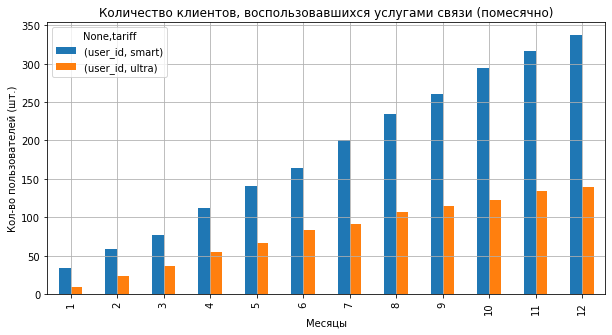

In [15]:
# динамика пользования услугами связи клиентов по тарифам
df_temp = df_svod.pivot_table(index=['month'], columns='tariff', aggfunc={'user_id':'count'})
ax = df_temp.plot(kind='bar',figsize=(10,5), grid=True)
ax.set_title("Количество клиентов, воспользовавшихся услугами связи (помесячно)")
ax.set_xlabel("Месяцы")
ax.set_ylabel("Кол-во пользователей (шт.)");

### Анализ выбросов в данных по тарифам
**Анализируемые показатели:**
* calls_sum - кол-во потраченных клиентом минут за месяц
* sms_count - кол-во сообщений
* mb_sum - объем интренет-трафика в Мб
* revenue - выручка


 --------------------------- Показатель: calls_sum


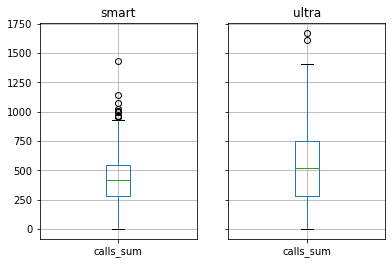

,Значения показателей_smart,Значения показателей_ultra
q1,282.000000,284.000000
q3,545.000000,752.000000
min_range,0.000000,0.000000
max_range,939.500000,1454.000000
out_share,0.400000,0.200000
mean_all,417.934948,526.623350
mean_range,415.054980,524.356053



 --------------------------- Показатель: sms_count


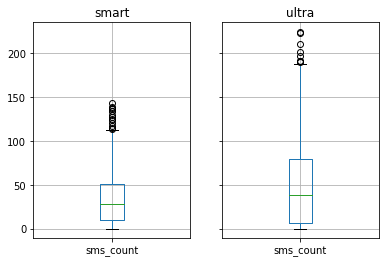

,Значения показателей_smart,Значения показателей_ultra
q1,10.000000,6.000000
q3,51.000000,79.000000
min_range,0.000000,0.000000
max_range,112.500000,188.500000
out_share,0.600000,0.800000
mean_all,33.384029,49.363452
mean_range,32.784650,48.101331



 --------------------------- Показатель: mb_sum


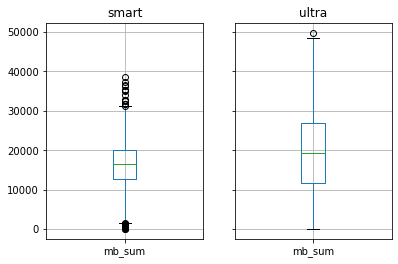

,Значения показателей_smart,Значения показателей_ultra
q1,12658.000000,11785.000000
q3,20068.000000,26863.000000
min_range,1543.000000,0.000000
max_range,31183.000000,49480.000000
out_share,1.700000,0.100000
mean_all,16229.188425,19486.901523
mean_range,16276.736314,19456.106707



 --------------------------- Показатель: revenue


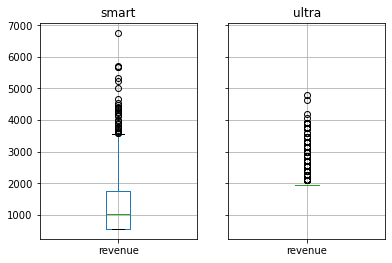

,Значения показателей_smart,Значения показателей_ultra
q1,550.00000,1950.00000
q3,1750.00000,1950.00000
min_range,550.00000,1950.00000
max_range,3550.00000,1950.00000
out_share,1.40000,13.60000
mean_all,1294.63930,2071.06599
mean_range,1249.74101,1950.00000


In [16]:
df_x = df_svod.groupby('tariff') #получаю 2 выборки по тарифам

# для каждого показателя анализирую выбросы
for i in ['calls_sum', 'sms_count', 'mb_sum', 'revenue']: 
    print(f"\n --------------------------- Показатель: {i}")
    df_x.boxplot(column=i); 
    plt.show()
    # расчет дополнительных статистических показателей
    display(mf_box_range(df_x.get_group('smart')[i], 1.5).
            join(mf_box_range(df_x.get_group('ultra')[i], 1.5), lsuffix='_smart', rsuffix='_ultra'))
    # ---------- пояснение рассчитанных показателей:
    # min_range - нижняя граница доверительного интервала
    # max_range - верхняя граница доверительного интервала
    # out_share - доля строк за границами доверительного интервала (размаха усов) в %
    # mean_all - среднеарфметическое по всем данным
    # mean_range - среднеарфметическое в пределах доверительного интервала
    # min_range_reserv - нижняя граница доверительного интервала c запасом в 20% от IQR вниз
    # max_range_reserv - верхняя граница доверительного интервала c запасом в 20% от IQR вверх

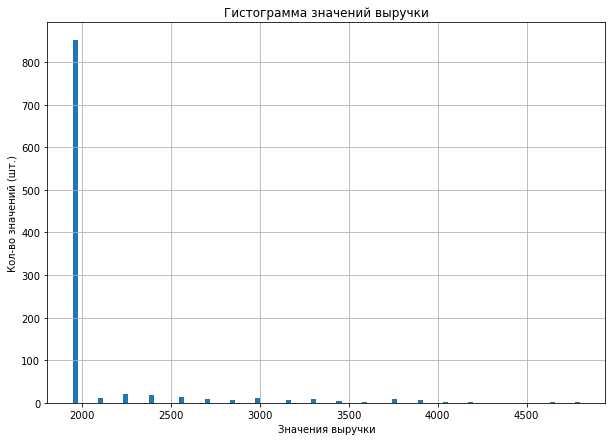

In [17]:
# факультативный (дополнительный) анализ выручки по тарифу ultra
df_temp = df_svod[df_svod['tariff'] == 'ultra']['revenue']
ax = df_temp.plot(kind='hist', bins=100, figsize=(10,7), grid=True)
ax.set_title("Гистограмма значений выручки")
ax.set_xlabel("Значения выручки")
ax.set_ylabel("Кол-во значений (шт.)");

### Анализ статистических характеристик

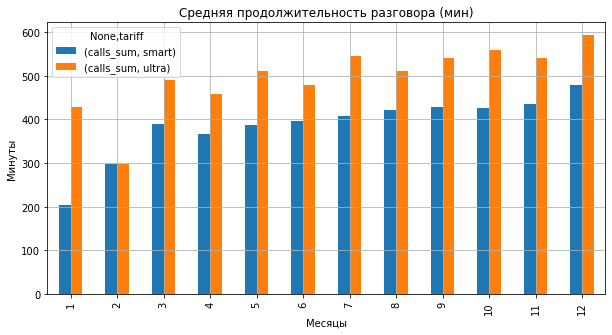

tariff                 smart          ultra
calls_sum mean    417.934948     526.623350
          std     190.313730     317.606098
          var   36219.315784  100873.633397

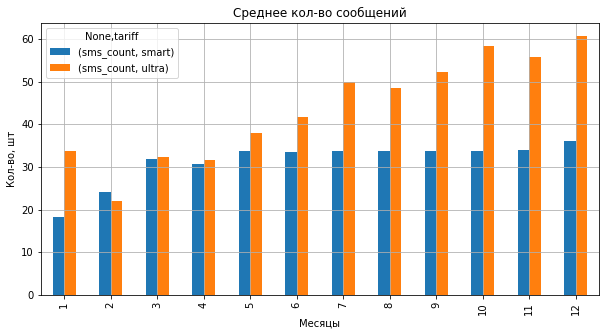

tariff               smart        ultra
sms_count mean   33.384029    49.363452
          std    28.227876    47.804457
          var   796.812958  2285.266143

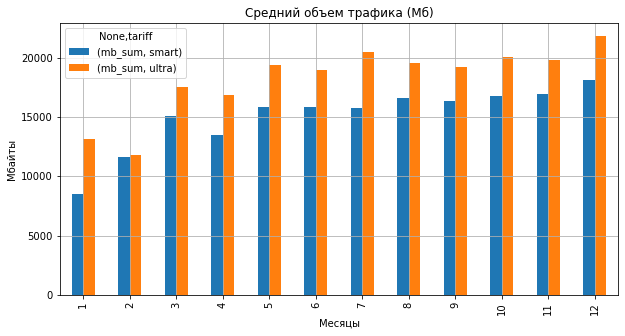

tariff              smart         ultra
mb_sum mean  1.622919e+04  1.948690e+04
       std   5.877577e+03  1.009632e+04
       var   3.454591e+07  1.019356e+08

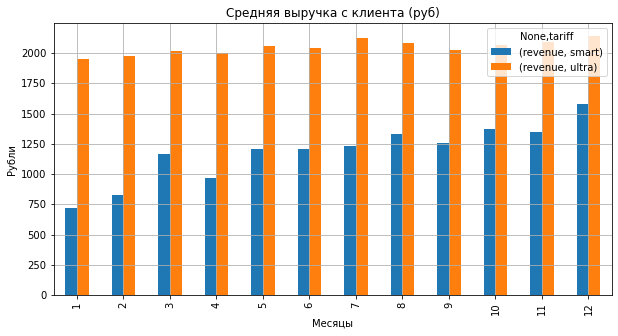

tariff                smart          ultra
revenue mean    1294.639300    2071.065990
        std      820.933202     378.802377
        var   673931.321363  143491.240560

In [18]:
# подсчет статистических показателей
set1 = {'calls_sum':'Средняя продолжительность разговора (мин)','sms_count':'Среднее кол-во сообщений',\
             'mb_sum':'Средний объем трафика (Мб)', 'revenue':'Средняя выручка с клиента (руб)'}
set2 = {'calls_sum':'Минуты','sms_count':'Кол-во, шт',\
             'mb_sum':'Мбайты', 'revenue':'Рубли'}

for i in set1:
    # помесячные значения средней
    df_temp = df_svod.pivot_table(index=['month'], columns='tariff', aggfunc={i:'mean'})
    ax = df_temp.plot(kind='bar',figsize=(10,5), grid=True, title=set1[i])
    ax.set_xlabel("Месяцы")
    ax.set_ylabel(set2[i])
    plt.show()

    # статхарактеристики за весь год
    display(df_svod.pivot_table(columns='tariff', aggfunc={i:['mean', 'std','var']}))

### Анализ распределений

================== Показатель calls_sum
----------- Тариф smart


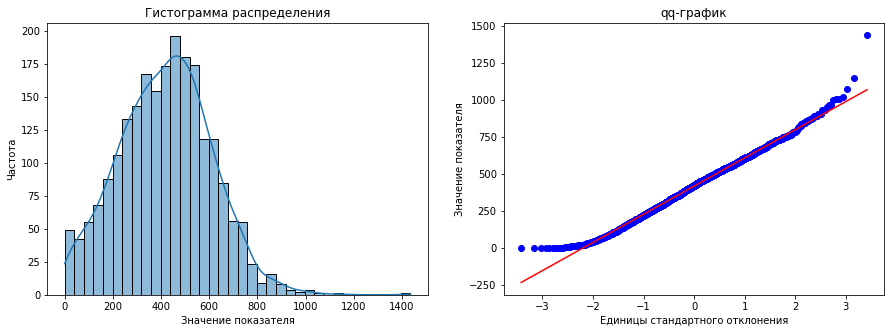

----------- Тариф ultra


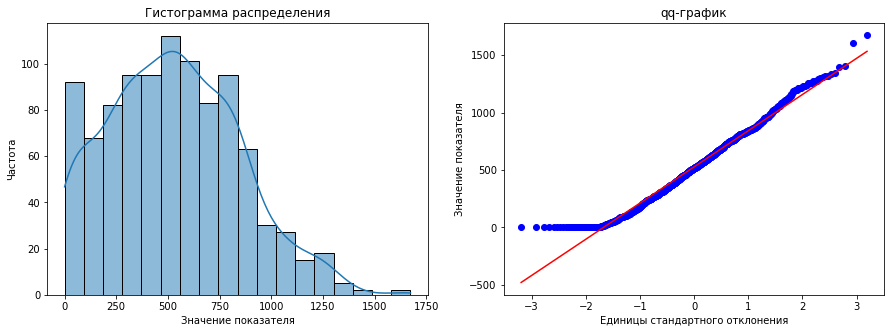

================== Показатель sms_count
----------- Тариф smart


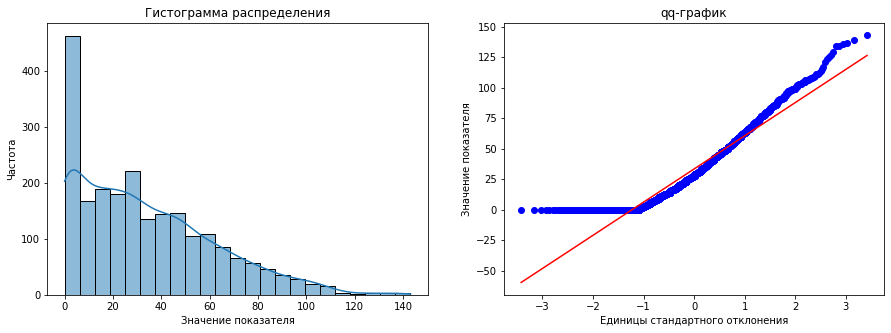

----------- Тариф ultra


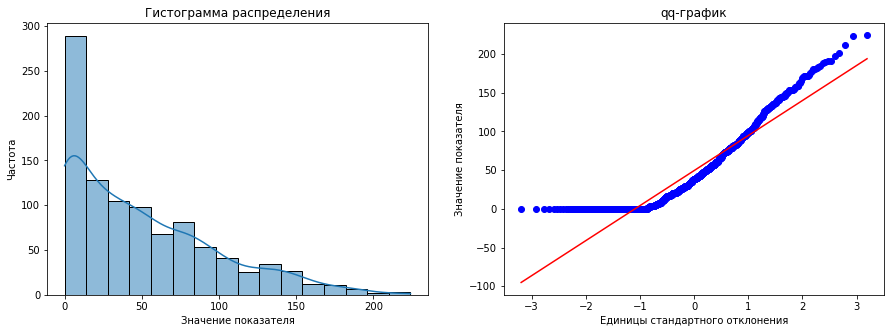

================== Показатель mb_sum
----------- Тариф smart


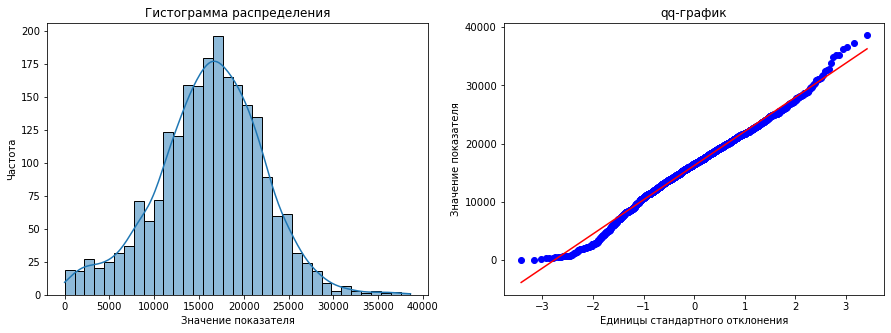

----------- Тариф ultra


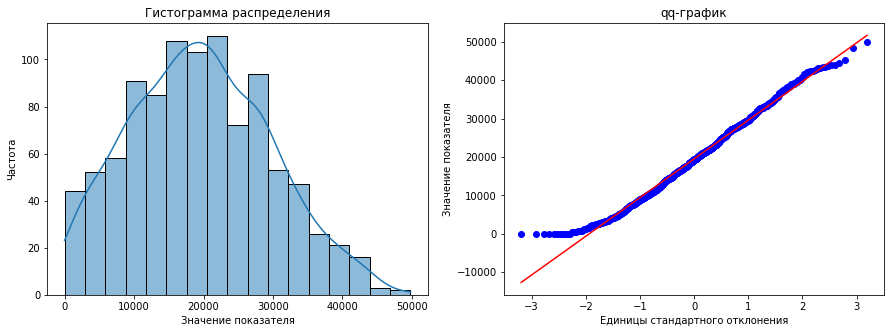

================== Показатель revenue
----------- Тариф smart


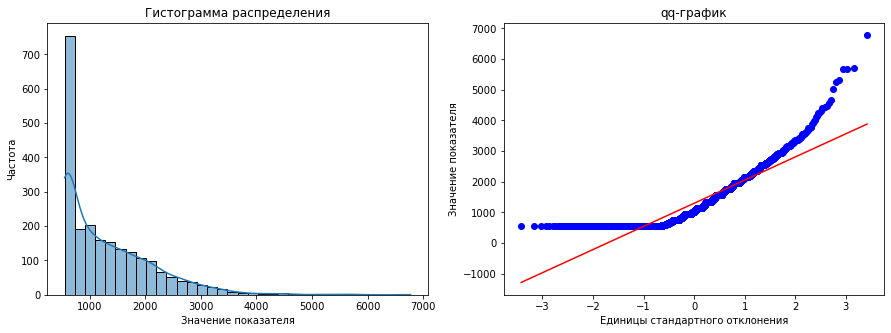

----------- Тариф ultra


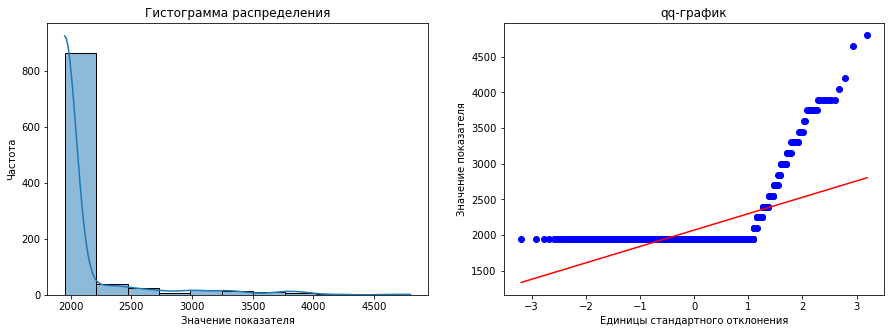

In [19]:
for j in ['calls_sum', 'sms_count', 'mb_sum', 'revenue']: # цикл по показателям
    print(f"================== Показатель {j}")
    for i in ['smart', 'ultra']: # цикл по тарифам
        print(f'----------- Тариф {i}')  
        plt.figure(figsize=(15,5)) # задание размера графика
        
        # гистограмма
        plt.subplot(1,2,1) # позиционирование графика
        ax = sb.histplot(df_svod.query("tariff==@i")[j], kde=True) # построение плотности распределения
        ax.set_title("Гистограмма распределения")
        ax.set_xlabel("Значение показателя")
        ax.set_ylabel("Частота")
        
        # qq-графики
        ax = plt.subplot(1,2,2)
        # проверка на нормальность распределения по qq-графикам
        #st.probplot(df_svod.query("tariff==@i")[j], dist="norm", plot=plt) 
        st.probplot(df_svod.query("tariff==@i")[j], dist="norm", plot=ax) 
        ax.set_title('qq-график')
        ax.set_xlabel("Единицы стандартного отклонения")
        ax.set_ylabel("Значение показателя")
        plt.show()

<div class="alert alert-block alert-info">
Промежуточный вывод по разделу: 
</div>

Гистограммы распределения и qq-графики по всем показателям (кроме потребляемого трафика) далеки от нормального, в связи с чем применять параметрический ttest для проверки гипотез не желательно, вместо него необходимо истользовать тест Манна-Уитни.

### Гипотизы и их проверка

**Гипотиза № 1:** "средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются"
* нулевая гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» равны,
* альтернативная гипотеза: средняя выручка пользователей тарифов «Ультра» больше или меньше средней выручки тарифа «Смарт» (двусторонняя),

**Гипотиза № 2:** "средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов"
* нулевая гипотеза: средняя выручка пользователей Москвы совпала со средней выручкой других регионов,
* альтернативная гипотеза: средняя выручка пользователей тарифов Москвы больше или меньше средней выручки других регионов (двусторонняя)

**Общее для двух гипотиз:**
 т.к. все выручки обрезаны слева (за счет взимания ежемесячной абонентской платы) их распределения точно не будут нормальными, в связи с чем применение ttest (тест Стьюдента) использовать было бы ошибкой, в связи с чем будет применен тест Манна-Уитни,

**Методические пояснения по формулировке гипотез:**
* нулевая гипотеза всегда предполагает равенство выборок,
* альтернативная гипотеза всегда предполагает отличие выборок не важно в какую сторону - двусторонняя, или в определенную сторону - односторонняя. 

In [20]:
# моя проверка после ревью: важный момент размер выборок при проверке стат гипотез: объемы выборок могут отличаться
print(len(df_svod.query("tariff == 'ultra'")['revenue']))
print(len(df_svod.query("tariff == 'smart'")['revenue']))

985
2229


In [21]:
print('ultra:{}\nsmart:{}'.format(df_svod.query("tariff == 'ultra'")['revenue'].mean(), 
                                  df_svod.query("tariff == 'smart'")['revenue'].mean()))
if 0:
    df_svod.query("tariff == 'ultra'")['revenue'].sum()
    df_svod.query("tariff == 'smart'")['revenue'].sum()

ultra:2071.0659898477156
smart:1294.6393001345896


In [22]:
# введем уровень значимости
alpha = 0.05

# проверка гипотизы №1
print(" ------  Проверка гипотизы №1 (средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются)")
results = st.mannwhitneyu(df_svod.query("tariff == 'ultra'")['revenue'],
                          df_svod.query("tariff == 'smart'")['revenue'],
                          alternative='two-sided')
print(f"p-значение: {round(results.pvalue*100,1)} %")

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
# проверка гипотизы №2
print("\n\n ------  Проверка гипотизы №2 (средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов)")
results = st.mannwhitneyu(df_svod.query("city == 'Москва'")['revenue'],
                          df_svod.query("city != 'Москва'")['revenue'],
                          alternative='two-sided')
print(f"p-значение: {round(results.pvalue*100,1)} %")

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

 ------  Проверка гипотизы №1 (средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются)
p-значение: 0.0 %
Отвергаем нулевую гипотезу


 ------  Проверка гипотизы №2 (средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов)
p-значение: 38.4 %
Не получилось отвергнуть нулевую гипотезу


### Выводы
* количество клиентов, пользующихся услугами связи, по тарифу smart почти линейно растет от месяца к месяцу, по тарифу ultra - также отмечается линейный рост клиентов в первом полугодии, однако со второго полугодия темпы прироста чуть снизились,

**анализ выбросов:**
* анализ выбросов данных (метрика out_share - доля строк за пределами усов) по показателям ("продолжительность разговора", "потребляемый трафик", "расходы за месяц" (для тарифа smart)) небольшая и не превысила 4% по каждому показателю соответственно,
* по "расходам за месяц" в тарифе ultra только 13,6% строк выбиваются за верхнюю границу доверительного интервала (уса),
* наибольшая доля выбросов сосредаточена в показателе "кол-во сообщений" по тарифу smart - 14.4%, по тарифу ultra - 20.4%.
* по ежемесячной выручке в тарифе smart все выбросы сосредоточены выше доверительного интервала, их доля составила 1.4%, 
* по тарифу ultra ежемесячная выручка стабильно держится в рамках абонентской платы в 1950 руб., что не позволило посчитать доверительный интревал, и только 13,6% строк данных превысили этот показатель.
* из специфики анализируемых данных очистку от выбросов проводить не целесообразно, т.к. значения по показателям, лежащим ниже и выше границы доверительного интервала - явление нормальное для услуг связи и не является ошибкой в данных,

**анализ статистических характеристик**
* средняя продолжительность разговоров клиентов с начала года показывает в основном положительную динамику роста с небольшими локальными впадинами по обоим тарифам, причем значения показателя не превышают количество минут, включенным в абонентскую плату тарифов,
* среднее кол-во сообщений на протяжении всего года не выходило за предельные показатели (свыше бесплатного объема), причем по тарифу smart рост показателя в первом квартале сменился стагнацией с незначительным ростом в конце года, по тарифу ultra в течение года наблюдается валатильная динамика показателя от месяца к месяцу, которую можно характеризовать в среднем как рост,
* средний объем трафика по обоим тарифам характеризуется ростом с января по май и дальнейшей стагнацией с небольшим ростом в декабре,
* средняя выручка по тарифу smart показывает уверенный рост на протяжении всего года, значение показателя по всем месяцам  превышает абонентскую плату,
* средняя выручка по тарифу ultra на протяжении года показывает небольшое превышение абонентской платы, однако в динамике роста показателя не наблюдается,

**анализ распределений**
* гистограммы распределения и qq-графики по всем показателям (кроме потребляемого трафика) далеки от нормального, в связи с чем применять параметрический ttest для проверки гипотез не желательно, вместо него необходимо истользовать тест Манна-Уитни,

**гипотизы и их проверка**
* гипотеза о равенстве выручки пользователей тарифов «Ультра» и «Смарт» на уровне значимости в 0% была отвергнута, т.е. найдена значимая разница в выручке двух тарифов,
* гипотеза о совпадении выручки Москвы и других регионов по обоим тарифам пользователей на уровне значимости в 38,4% не была отвергнута.

## Общий вывод
**изучение, предобработка данных и расчеты результатов**
* были загружены и проанализированы таблицы с данными о клиентах и их потреблении услуг сотовой связи,
* по некторым полям таблиц выполнена обработка данных (округление) и преобразование типов, 
* пропуски и дубли в данных не обнаружены,
* данные из разных сущностных таблиц для удобства дальнейшей обработки объединены в единую таблицу,
* количество клиентов, пользующихся услугами связи, по тарифу smart почти линейно растет от месяца к месяцу, по тарифу ultra - также отмечается линейный рост клиентов в первом полугодии, однако со второго полугодия темпы прироста чуть снизились,
* из специфики анализируемых данных очистку от выбросов проводить не целесообразно, т.к. значения по показателям, лежащим ниже и выше границы доверительного интервала - явление нормальное для услуг связи и не является ошибкой в данных,

**анализ статистических характеристик**
* средняя продолжительность разговоров клиентов с начала года показывает в основном положительную динамику роста с небольшими локальными впадинами по обоим тарифам, причем значения показателя не превышают количество минут, включенным в абонентскую плату тарифов,
* среднее кол-во сообщений на протяжении всего года не выходило за предельные показатели (свыше бесплатного объема), причем по тарифу smart рост показателя в первом квартале сменился стагнацией с незначительным ростом в конце года, по тарифу ultra в течение года наблюдается валатильная динамика показателя от месяца к месяцу, которую можно характеризовать в среднем как рост,
* средний объем трафика по обоим тарифам характеризуется ростом с января по май и дальнейшей стагнацией с небольшим ростом в декабре,
* средняя выручка по тарифу smart показывает уверенный рост на протяжении всего года, значение показателя по всем месяцам  превышает абонентскую плату,
* средняя выручка по тарифу ultra на протяжении года показывает небольшое превышение абонентской платы, однако в динамике роста показателя не наблюдается,

**анализ распределений**
* по всем показателям (кол-во потраченных минут, сообщений, трафика, выручке) по обоим тарифам распределения не относятся к нормальным распределениям, в связи с чем применять параметрический ttest для проверки гипотез не желательно, вместо него необходимо истользовать тест Манна-Уитни,

**гипотизы и их проверка**
* гипотеза о равенстве средней выручки пользователей тарифов «Ультра» и «Смарт» на уровне значимости в 0% была отвергнута, т.е. найдена значимая разница в выручке двух тарифов,
* гипотеза о равентсве средней выручки по Москве и по другим регионам по обоим тарифам пользователей на уровне значимости в 38,4% была принята.

[В начало](#intro)